# Prototyping: Model Serving with Additional Modules via Mounting Filesystem

This will allow you to utilize other files and modules you have created outside of your `serve.py` file. This method is simple and can be used for prototyping, but is not best practice

We will be doing the following:
1. Mount the current directory in the container
2. Add the current directory to the Python path within the container

In [11]:
import os
import mlrun

# Create MLRun project
project = mlrun.get_or_create_project(name="model-serving-additional-modules", context="./")

> 2023-03-29 23:13:38,191 [info] loaded project model-serving-additional-modules from MLRun DB


### Log Model

In [12]:
project.log_model(
    key="iris_model",
    model_file="iris_model.pkl",
    metrics={"loss" : 0.01, "accuracy" : 0.96},
    framework="sklearn",
    algorithm="RandomForestClassifier"
)

In [13]:
model_uri = project.get_artifact_uri("iris_model")
model_uri

'store://artifacts/model-serving-additional-modules/iris_model'

### Create Additional Module and Model Server

In [15]:
%%writefile my_module.py

def something_useful():
    return "something useful"

Overwriting my_module.py


In [17]:
%%writefile serve.py
import mlrun

from cloudpickle import load
from typing import List
import numpy as np

################################################
from my_module import something_useful # <------
################################################

class MyUsefulModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return something_useful() # <-----

Overwriting serve.py


In [18]:
# Create serving function
serve = project.set_function(
    name="model-server-1",
    func="serve.py",
    kind="serving",
    image="mlrun/mlrun",
)

serve.add_model(key=f"iris", model_path=model_uri, class_name="MyUsefulModel")

###################################################
# This is the extra piece we are adding. This
# works fine for prototyping but is not best
# practice for production. Instead you should
# use a Git repo

# Mount the Iguazio filesystem inside our model server
serve.apply(mlrun.mount_v3io())

# Add the current directory to the Python path
# inside our model server
serve.set_env(name="PYTHONPATH", value=os.getcwd())
###################################################

In [19]:
serve.with_requests(mem="1G", cpu=0.1)
serve.with_limits(mem="2G", cpu=0.2)

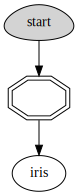

In [20]:
serve.plot()

In [21]:
# print(serve.to_yaml())

In [22]:
addr = serve.deploy()

> 2023-03-29 23:14:39,592 [info] Starting remote function deploy
2023-03-29 23:14:40  (info) Deploying function
2023-03-29 23:14:40  (info) Building
2023-03-29 23:14:40  (info) Staging files and preparing base images
2023-03-29 23:14:40  (info) Building processor image
2023-03-29 23:15:46  (info) Build complete
2023-03-29 23:16:43  (info) Function deploy complete
> 2023-03-29 23:16:43,558 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-model-serving-additional-modules-model-server-1.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['model-serving-additional-modules-model-server-1-model-0wsqfyfw.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


In [23]:
addr

'http://model-serving-additional-modules-model-server-1-model-0wsqfyfw.default-tenant.app.us-sales-350.iguazio-cd1.com/'

### "Predict"
Note the output is using our additional module we created

In [25]:
serve.invoke(path="/v2/models/iris/predict", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-03-29 23:17:14,862 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-serving-additional-modules-model-server-1.default-tenant.svc.cluster.local:8080/v2/models/iris/predict'}


{'id': '84bc81bd-b372-4ded-9a1e-0966903376e6',
 'model_name': 'iris',
 'outputs': 'something useful'}